In [1]:
import argparse
from math import log10
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
import torch.cuda as cuda

import time
import numpy as np
import os
from RANet_lib import *
from RANet_lib.RANet_lib import *
from RANet_model import RANet as Net
import os
import os.path as osp
from glob import glob

import matplotlib.pyplot as plt
from torchvision import transforms
import PIL.Image as Image

from vj_davis_17_loader import Custom_DAVIS2017_dataset, Custom_DAVIS2017_testing_dataset
from torch.utils.data import DataLoader
from vj_loss_functions import *

In [99]:
def Dtype(data):
    return torch._C._TensorBase.float(data)
def P2masks(self, P, num):
    M = []
    M.append(self.Dtype((P == 0) + (P > int(num))))
    for idx in range(1, num + 1):
        M.append(self.Dtype(P == idx))
    return M
def get_single_masks(template_msk, target_msk):
    for idx in range(len(template_msk)):
        max_obj = template_msk[idx,0].max().int().data.cpu().numpy()
        target_msk_images = P2masks(F.relu(target_msk[idx,0] - 1), max_obj - 1)
        for i in range(max_obj-1):
            prediction_single_masks.append(Out[idx][0,i].reshape(-1))
            target_single_masks.append(target_msk_images[i+1].reshape(-1))
    return 
def msks2P(msk, objs_ids = None, threshold=0.5):
    '''
    Msks is expected to be of dimension num_objects x W x H
    '''
    
    if objs_ids is not None and len(msk) != len(objs_ids):
        print('error, len(msks) != len(objs_ids)')
    return msk.max(dim=0)[0].ge(threshold).long()*(msk.argmax(dim=0)+1)

def P2msks(Img, objs_ids):
    img = np.array(Img)
    Imgs = []
    for idx in objs_ids:
        Imgs.append(Image.fromarray((img == idx) * 255.0).convert('L'))
    return Imgs

def msks2P(msks, objs_ids):
    # if max_num == 1:
    #     return msks[0]
    if len(msks) != len(objs_ids):
        print('error, len(msks) != len(objs_ids)')
    P = torch.zeros(msks[0].size())
    for idx, msk in enumerate(msks):
        ids = torch.nonzero(msk)
        if len(ids) > 0:
            P[ids[:, 0], ids[:, 1], ids[:, 2]] = idx + 1
    return P

In [122]:
def get_iou(ip, t):
    # expects batch_size x Wx H binary value images
    batch_size = len(ip)
    ip = ip.view(batch_size,-1)
    t = t.view(batch_size, -1)
    intersection = (ip*t).sum(dim=1)
    union = ip.sum(dim=1) + t.sum(dim=1) - intersection
    return intersection/union

def iou_score(predictions, targets, min_objs = 1, names=None):
    # Both should be lists with dimensions in batch_size x count_images x W x H
    
    loss = torch.zeros(1).to(targets[0].device)
    for batch, (pred, tar) in enumerate(zip(predictions, targets),1):
        if (pred.max() != tar.max()):
            print("mis matched number of objects! num in pred: {}. num in target: {}"\
                  .format(list(set(np.asarray(pred[0]).reshape(-1))), list(set(np.asarray(tar[0]).reshape(-1))) ) )
            
        objs_ids = list(set(np.asarray(pred[0]).reshape(-1)))
        print("batch:", batch, "object ids:", objs_ids)
        max_objs = len(objs_ids)
        img_loss = torch.zeros(1).to(tar[0].device)
        for i in range(min_objs, max_objs):
            iou = get_iou(pred.eq(objs_ids[i]).float(), tar.eq(objs_ids[i]).float()).mean()
            if (names is not None):
                print("object:", names[batch-1] + '_' + str(i), "iou:", iou.item())
            img_loss += iou
        img_loss = img_loss/(max_objs-min_objs)

        loss += img_loss
    return loss

In [117]:
davis_img_folder = '../datasets/DAVIS/Annotations/480p/'
results_folder = '../predictions/IOU_disc_scale_05_epoch0_re/'
davis_img_folder2 = '../../davis2017-evaluation/results/semi-supervised/osvos/'

In [118]:
trnsfm = transforms.ToTensor()
resizer = PAD_transform((480,864), random=False)

In [126]:
file_list =  sorted(os.listdir(davis_img_folder2))

folder = file_list[0]
images =  sorted(os.listdir(results_folder+folder))

img_list1 = []
img_list2 = []
img_list3 = []
img_list1_ = []
img_list2_ = []
for img in images:
    img1 = Image.open(results_folder+folder + '/' + img)
    img2 = Image.open(davis_img_folder+folder + '/' + img)
    img3 = Image.open(davis_img_folder2+folder + '/' + img)
    
#     objs_ids = list(set(np.asarray(img1).reshape(-1)))
#     P2msks(base_mask, objs_ids)
    
    img_list1.append(trnsfm(img1))
    img_list2.append(trnsfm(img2))
    img_list3.append(trnsfm(img3))
    
    objs_ids = list(set(np.asarray(img1).reshape(-1)))
    img1_ = resizer(P2msks(img1, objs_ids), norm=[1, 0])
    img1_ = msks2P(img1_, objs_ids)[0].unsqueeze(0)
    
    objs_ids = list(set(np.asarray(img2).reshape(-1)))
    img2_ = resizer(P2msks(img2, objs_ids), norm=[1, 0])
    img2_ = msks2P(img2_, objs_ids)[0].unsqueeze(0)
    
    img_list1_.append(img1_)
    img_list2_.append(img2_)

img_list1 = torch.cat(img_list1, dim=0)
img_list2 = torch.cat(img_list2, dim=0)
img_list3 = torch.cat(img_list3, dim=0)
img_list1_ = torch.cat(img_list1_, dim=0)
img_list2_ = torch.cat(img_list2_, dim=0)

In [127]:
iou = iou_score([img_list1.float()], [img_list2.float()], min_objs=1, names=[folder] )

batch: 1 object ids: [0.0, 0.007843138, 0.003921569]


RuntimeError: The size of tensor a (414720) must match the size of tensor b (436800) at non-singleton dimension 1

In [133]:
iou = iou_score([img_list1_.float()], [img_list2_.float()], min_objs=1, names=[folder] )

batch: 1 object ids: [1.0, 2.0, 3.0]
object: bike-packing_1 iou: 0.6018927097320557
object: bike-packing_2 iou: 0.7967311143875122


In [111]:
iou = iou_score([img_list1_.float()], [img_list2_.float()], min_objs=2, names=[folder] )

batch: 1 object ids: [0.0, 1.0, 2.0, 3.0]
object: bike-packing_2 iou: 0.6062366366386414
object: bike-packing_3 iou: 0.7918944358825684


In [113]:
img_list1_.shape

torch.Size([69, 480, 864])

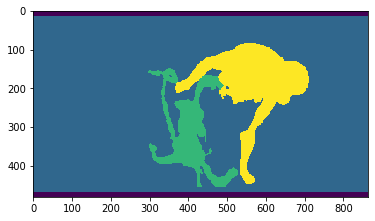

In [124]:
plt.imshow(img_list1_[-1].detach().numpy())

In [58]:
(img2-img3).abs().sum()

tensor(61.3336)

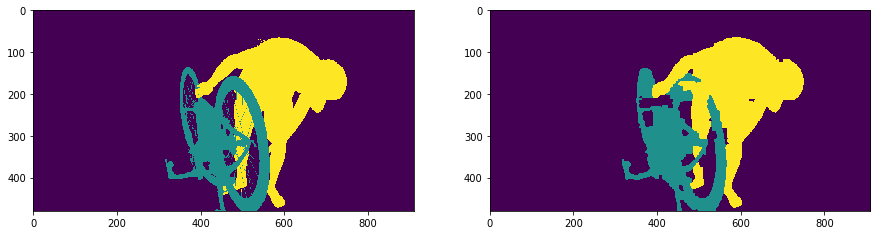

In [62]:
plt.figure(figsize=(15,8))
plt.subplot(1,2,1)
plt.imshow(img2.detach().numpy()[0])
plt.subplot(1,2,2)
plt.imshow(img3.detach().numpy()[0])

In [65]:
len(os.listdir(results_folder))

32